In [1]:
import os
import glob
import numpy as np
import torch
from torch.utils.data import Dataset
import tifffile
import json
import torchvision.transforms as T
from scipy.ndimage import zoom
import cv2
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from swinSASSL import SwinSASSL

In [2]:
class ClassificationDataset(Dataset):

    def __init__(self, root_dir, mask_type='random', augment=False, target_size=None):
        self.root_dir = root_dir
        self.mask_type = mask_type
        self.augment = augment
        self.target_size = target_size
       
        
        # Band names in order (12 bands total)
        self.bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
        
        self.band_resolutions = {
            'B1': 60, 'B2': 10, 'B3': 10, 'B4': 10,
            'B5': 20, 'B6': 20, 'B7': 20, 'B8': 10,
            'B8A': 20, 'B9': 60, 'B11': 20, 'B12': 20
        }
        
        self.samples = []
        for region_folder in tqdm(glob.glob(os.path.join(root_dir, '*'))):
            if os.path.isdir(region_folder):
                if(region_folder[-3:] == "RPH"): label = "RPH"
                elif(region_folder[-5:] == "Blast"): label = "Blast"
                elif(region_folder[-4:] == "Rust"): label = "Rust"
                elif(region_folder[-5:] == "Aphid"): label = "Aphid"
                else: continue

                for timestamp_folder in glob.glob(os.path.join(region_folder, '*')):
                    if os.path.isdir(timestamp_folder):
                        # Check if all bands exist
                        band_paths = {band: os.path.join(timestamp_folder, f'{band}.tif') 
                                     for band in self.bands}
                        if all(os.path.exists(p) for p in band_paths.values()):
                            self.samples.append((band_paths,label))
        
        print(f"Found {len(self.samples)} samples with all 12 bands")
    
    def __len__(self):
        return len(self.samples)
    def resize_band(self, band_data, target_shape):
        if band_data.shape == target_shape:
            return band_data
        
        resized = cv2.resize(
            band_data, 
            (target_shape[1], target_shape[0]),  # OpenCV uses (W, H)
            interpolation=cv2.INTER_LINEAR
        )
        return resized
    def load_multispectral_image(self, band_paths):
        bands_data = []
        shapes = []
        
        loaded_bands = {}
        for band in self.bands:
            img = tifffile.imread(band_paths[band])
            loaded_bands[band] = img
            shapes.append(img.shape)
        
        if self.target_size is not None:
            target_shape = self.target_size
        else:
            reference_band = loaded_bands['B4']  # 10m band
            target_shape = reference_band.shape
        
        # Second pass: resize all bands to target shape
        for band in self.bands:
            img = loaded_bands[band]
            
            # Resize if needed
            if img.shape != target_shape:
                img = self.resize_band(img, target_shape)
            
            bands_data.append(img)
        
        # Stack along channel dimension: (12, H, W)
        multi_band = np.stack(bands_data, axis=0)
        return multi_band 
    def normalize_sentinel2(self, img):
        """
        Normalize Sentinel-2 data to [0, 1]
        Sentinel-2 L1C has typical range 0-10000 (reflectance * 10000)
        """
        # Clip extreme values and normalize
        img = np.clip(img, 0, 10000)
        img = img.astype(np.float32) / 10000.0
        return img  
    def normalize_satlas(self,img):
        img = np.clip(img, 0, 8160)
        img = img.astype(np.float32) / 8160
        return img
    def create_random_mask(self, shape, num_masks=None):
        """Create random rectangular mask(s)"""
        C, H, W = shape
        mask = np.ones((C, H, W), dtype=np.float32)
        
        if num_masks is None:
            num_masks = np.random.randint(1, 4)
        
        for _ in range(num_masks):
            mask_h = np.random.randint(32, min(128, H // 2))
            mask_w = np.random.randint(32, min(128, W // 2))
            
            top = np.random.randint(0, H - mask_h)
            left = np.random.randint(0, W - mask_w)
            
            # Mask all channels
            mask[:, top:top+mask_h, left:left+mask_w] = 0
        
        return mask 
    def create_center_mask(self, shape, mask_ratio=0.25):
        """Create centered square mask"""
        C, H, W = shape
        mask = np.ones((C, H, W), dtype=np.float32)
        
        mask_size = int(min(H, W) * mask_ratio)
        top = (H - mask_size) // 2
        left = (W - mask_size) // 2
        
        mask[:, top:top+mask_size, left:left+mask_size] = 0
        return mask 
    def augment_data(self, img):
        """Random flips and rotations"""
        # Random horizontal flip
        if np.random.random() > 0.5:
            img = np.flip(img, axis=2).copy()
        
        # Random vertical flip
        if np.random.random() > 0.5:
            img = np.flip(img, axis=1).copy()
        
        # Random 90 degree rotations
        k = np.random.randint(0, 4)
        if k > 0:
            img = np.rot90(img, k, axes=(1, 2)).copy()
        
        return img
    
    def __getitem__(self, idx):

        band_paths,label = self.samples[idx]
        img = self.load_multispectral_image(band_paths)
        img = self.normalize_satlas(img)
        if(label == "RPH"): label = 0
        elif(label == "Blast"): label = 1
        elif(label == "Rust"): label = 2
        elif(label == "Aphid"): label = 3
        self.bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
        c9 = img[(3,2,1,4,5,6,7,10,11),:,:]
        c12 = img
        return {
            'c9': c9,      
            'c12': c12,
            'label': label
        }
        

In [3]:
import numpy as np
from torch.utils.data import Subset, DataLoader


def create_balanced_split(dataset, val_samples_per_class=20, max_train_per_class=100):
    """
    Create balanced train/val split with fixed number of samples per class
    
    Args:
        dataset: Your ClassificationDataset
        val_samples_per_class: Number of samples per class for validation
        max_train_per_class: Maximum number of samples per class for training
    
    Returns:
        train_indices, val_indices
    """
    # Get all labels
    all_labels = []
    for idx in range(len(dataset)):
        sample = dataset[idx]
        all_labels.append(sample['label'])
    
    all_labels = np.array(all_labels)
    
    # Get indices for each class
    class_indices = {
        0: np.where(all_labels == 0)[0],  # RPH
        1: np.where(all_labels == 1)[0],  # Blast
        2: np.where(all_labels == 2)[0],  # Rust
        3: np.where(all_labels == 3)[0],  # Aphid
    }
    
    # Print original class distribution
    print("Original class distribution:")
    class_names = ['RPH', 'Blast', 'Rust', 'Aphid']
    for cls_id, indices in class_indices.items():
        print(f"  {class_names[cls_id]}: {len(indices)} samples")
    
    train_indices = []
    val_indices = []
    
    print(f"\nSplitting with {val_samples_per_class} val and max {max_train_per_class} train per class:")
    
    # For each class, split into train/val
    for cls_id, indices in tqdm(class_indices.items()):
        # Shuffle indices for this class
        np.random.seed(42)  # For reproducibility
        shuffled = indices.copy()
        np.random.shuffle(shuffled)
        
        # Take first val_samples_per_class for validation
        val_idx = shuffled[:val_samples_per_class]
        
        # Take next max_train_per_class for training (limit to max)
        remaining = shuffled[val_samples_per_class:]
        train_idx = remaining[:max_train_per_class]
        
        # Calculate how many were left out
        left_out = len(remaining) - len(train_idx)
        
        val_indices.extend(val_idx)
        train_indices.extend(train_idx)
        
        print(f"  {class_names[cls_id]}: {len(train_idx)} train, {len(val_idx)} val, {left_out} left out")
    
    # Shuffle the final indices
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)
    
    print(f"\nFinal counts:")
    print(f"  Training: {len(train_indices)} samples")
    print(f"  Validation: {len(val_indices)} samples")
    print(f"  Total used: {len(train_indices) + len(val_indices)} / {len(dataset)}")
    
    return train_indices, val_indices


# Create dataset
cdata = ClassificationDataset(
    root_dir="C:\\Users\\ayush\\OneDrive\\Desktop\\Agriculture\\ICPR02\\kaggle",
    mask_type='random',
    augment=True,
    target_size=(256, 256)
)

# Create balanced split with limits
train_indices, val_indices = create_balanced_split(
    cdata, 
    val_samples_per_class=40,
    max_train_per_class=100  # Limit to 100 training samples per class
)

# Create Subset datasets
train_dataset = Subset(cdata, train_indices)
val_dataset = Subset(cdata, val_indices)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
)

print(f"\nDataLoaders created successfully!")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")


100%|██████████| 5/5 [00:00<00:00,  6.54it/s]


Found 900 samples with all 12 bands
Original class distribution:
  RPH: 495 samples
  Blast: 75 samples
  Rust: 40 samples
  Aphid: 290 samples

Splitting with 40 val and max 100 train per class:


100%|██████████| 4/4 [00:00<00:00, 951.57it/s]

  RPH: 100 train, 40 val, 355 left out
  Blast: 35 train, 40 val, 0 left out
  Rust: 0 train, 40 val, 0 left out
  Aphid: 100 train, 40 val, 150 left out

Final counts:
  Training: 235 samples
  Validation: 160 samples
  Total used: 395 / 900

DataLoaders created successfully!
Train batches: 15
Val batches: 10


In [4]:
class EmbeddingModel(nn.Module):
    def __init__(self, encoder_path = None, *args, **kwargs ,):
        super().__init__(*args, **kwargs)

        self.resize = T.Compose([T.Resize((256, 256))])
        self.swinSASSL = SwinSASSL(swin_in_channels=9)
        
        if encoder_path:
            checkpoint = torch.load(encoder_path, map_location='cpu')
            self.swinSASSL.load_state_dict(checkpoint["model_state_dict"])
            print(f"✓ Loaded encoder from {encoder_path}")
        
        for param in self.swinSASSL.parameters():
            param.requires_grad = False

    def forward(self,x):
        x = self.resize(x)
        x = self.swinSASSL.teacher(x)[3]
        x = self.swinSASSL.teacher_stack(x)
        return x
    

✓ Loaded encoder from satlas_sassl_checkpoints9\sassl_checkpoint_epoch_1.pth


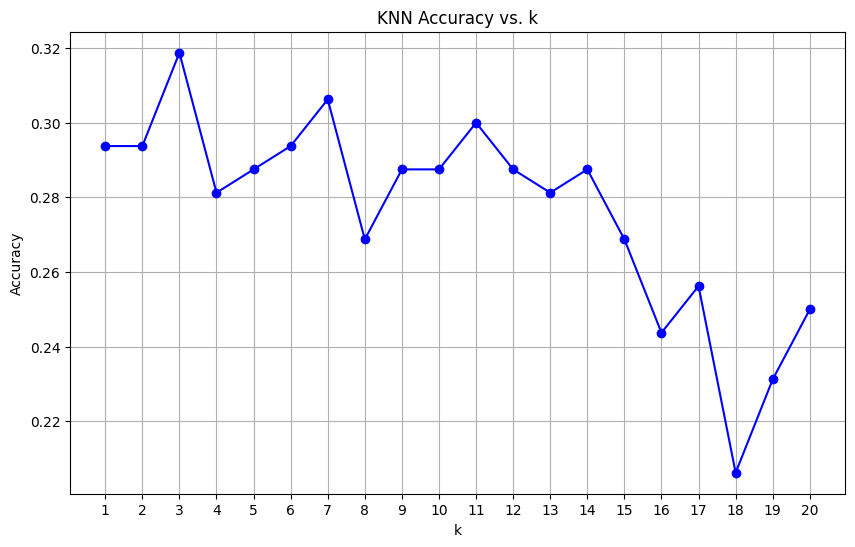

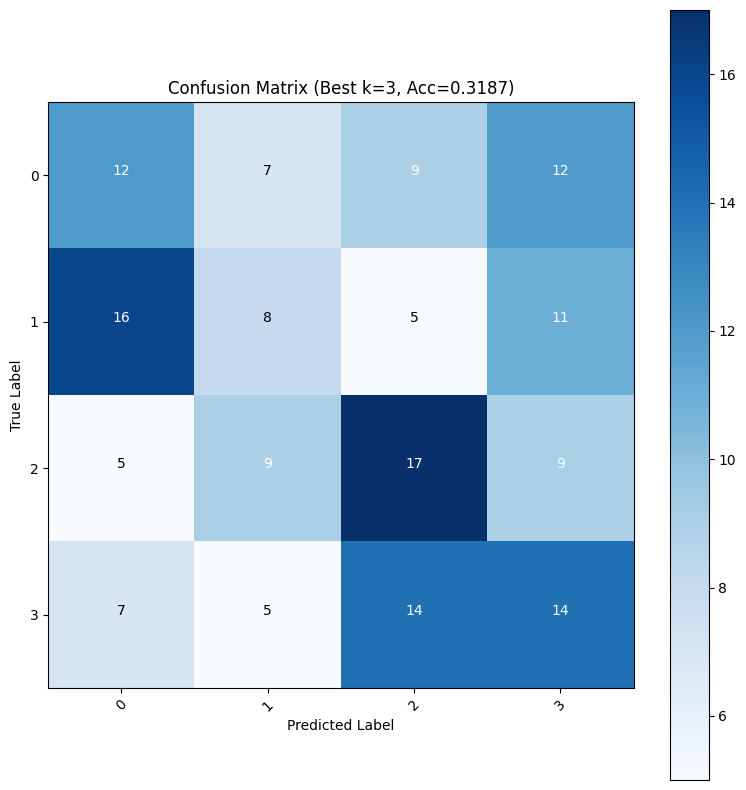

-0.055149186
✓ Loaded encoder from satlas_sassl_checkpoints9\sassl_checkpoint_epoch_4.pth


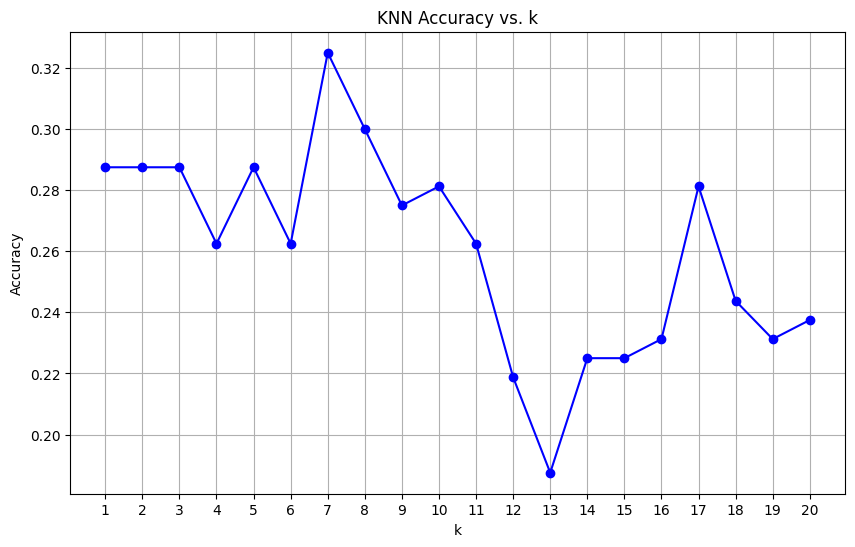

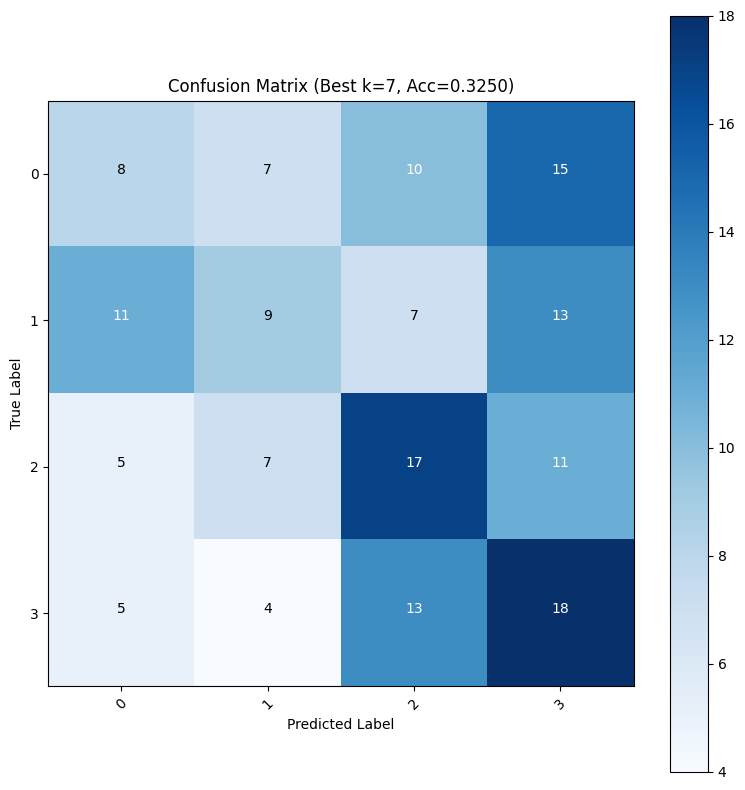

-0.06420717
✓ Loaded encoder from satlas_sassl_checkpoints9\sassl_checkpoint_epoch_8.pth


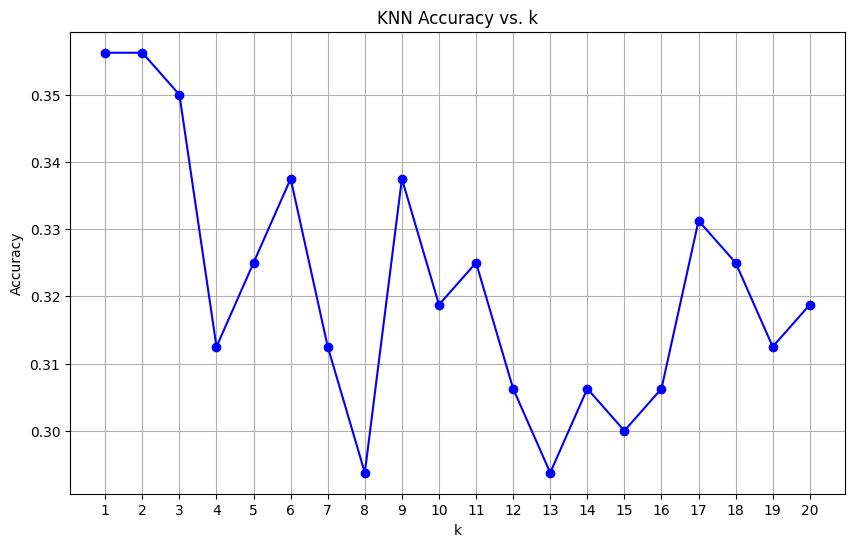

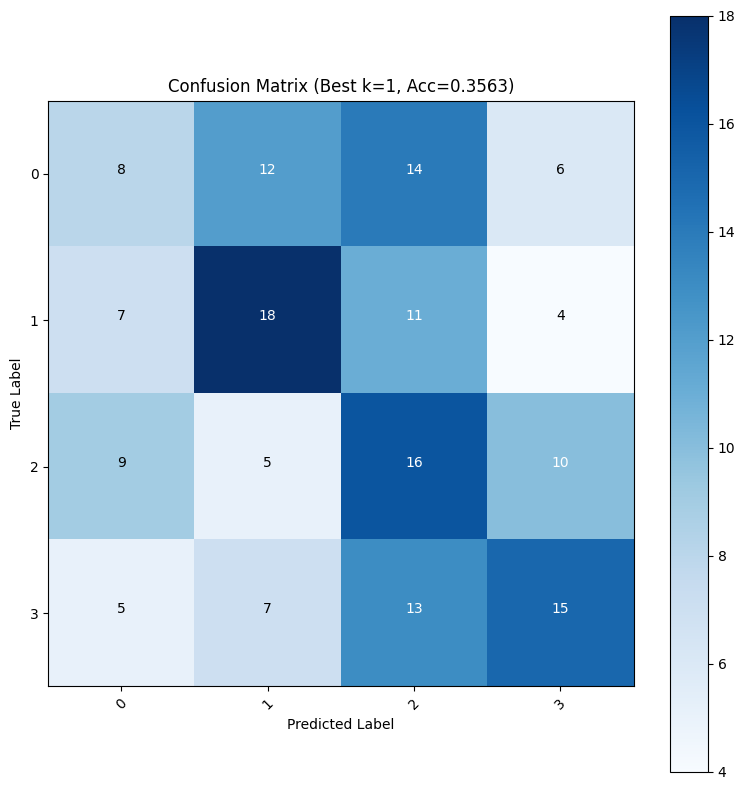

-0.073895544
✓ Loaded encoder from satlas_sassl_checkpoints9\sassl_checkpoint_epoch_12.pth


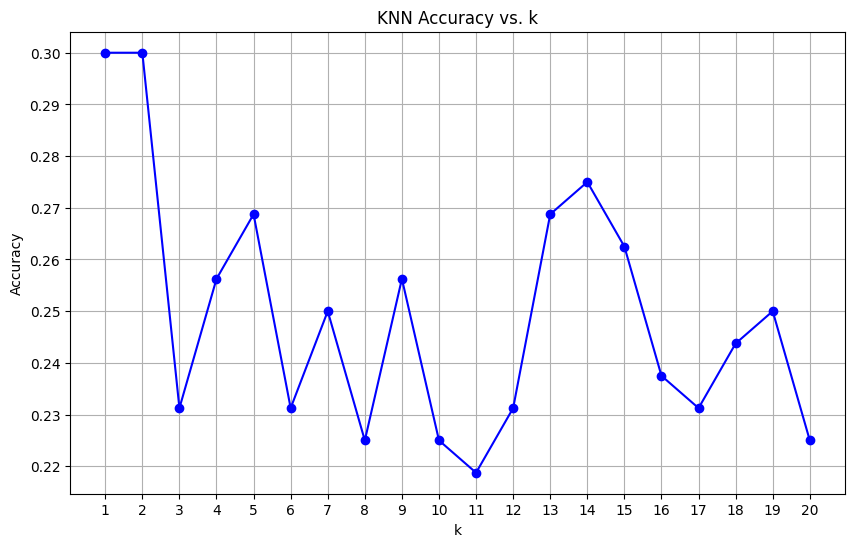

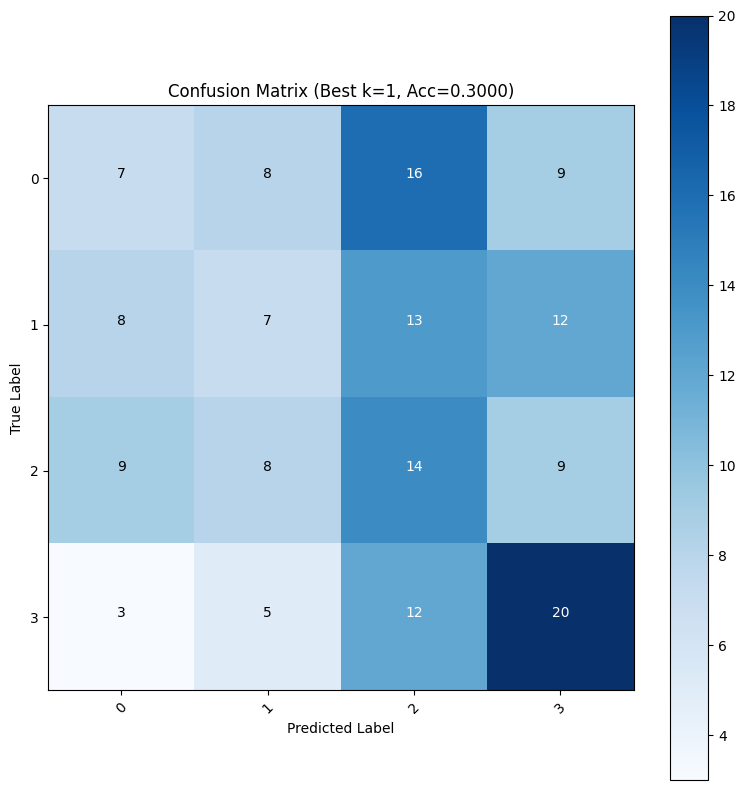

-0.09447247
✓ Loaded encoder from satlas_sassl_checkpoints9\sassl_checkpoint_epoch_16.pth


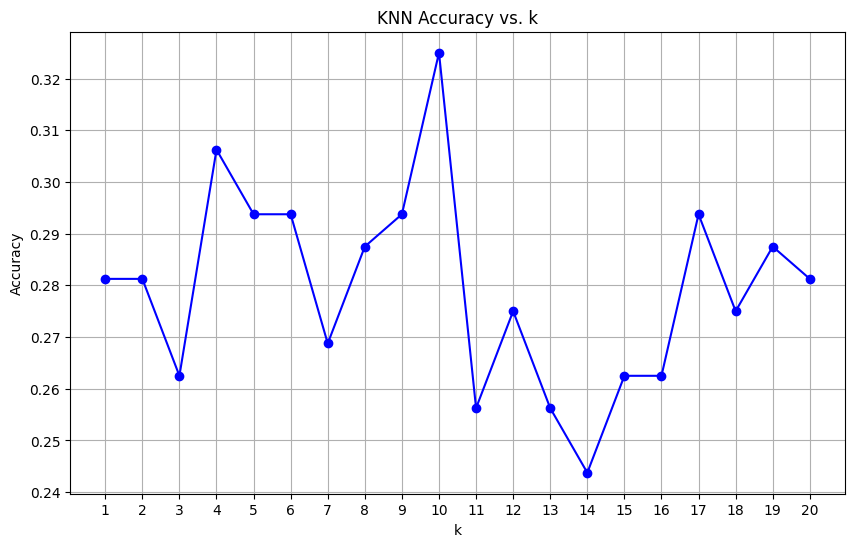

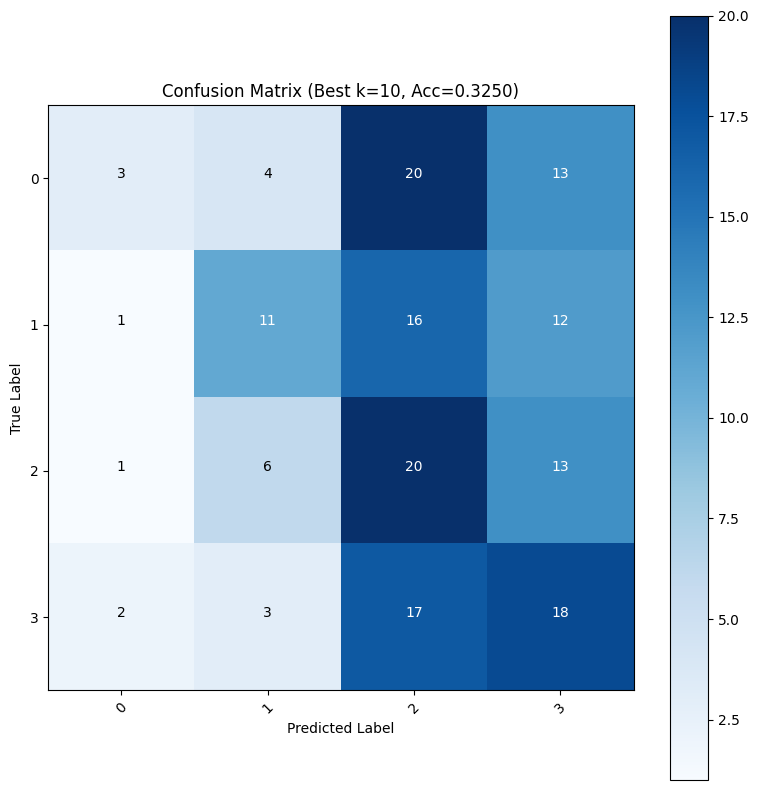

-0.0713252
✓ Loaded encoder from satlas_sassl_checkpoints9\sassl_checkpoint_epoch_20.pth


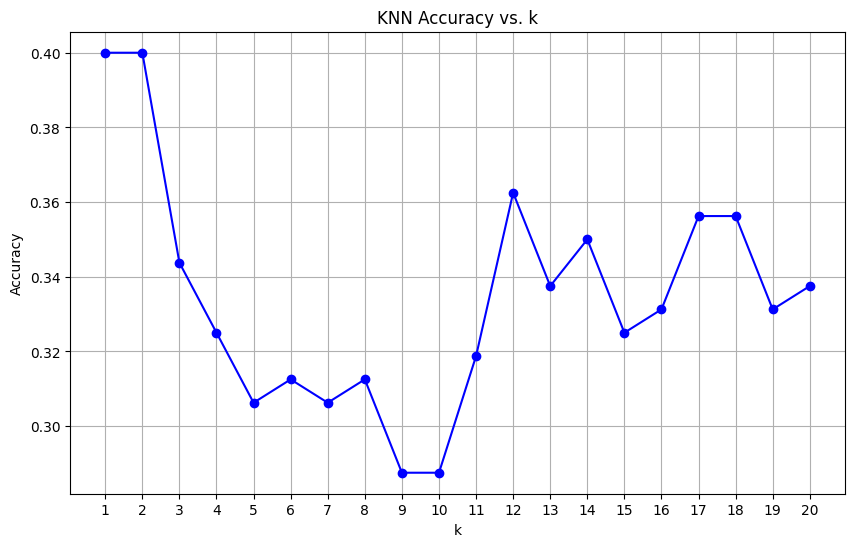

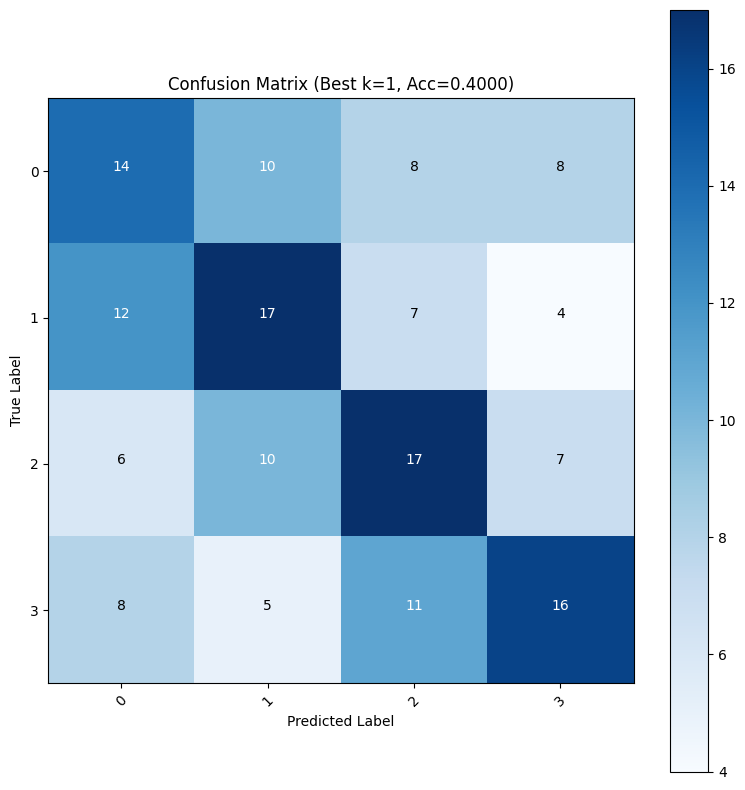

-0.13156548


In [5]:
from encoder_evals import evaluate_and_plot_k

for chk_path in ["satlas_sassl_checkpoints9\sassl_checkpoint_epoch_1.pth",
                 "satlas_sassl_checkpoints9\sassl_checkpoint_epoch_4.pth",
                 "satlas_sassl_checkpoints9\sassl_checkpoint_epoch_8.pth",
                 "satlas_sassl_checkpoints9\sassl_checkpoint_epoch_12.pth",
                 "satlas_sassl_checkpoints9\sassl_checkpoint_epoch_16.pth",
                 "satlas_sassl_checkpoints9\sassl_checkpoint_epoch_20.pth",
                ]:
    
    device = "cuda"
    model = EmbeddingModel(chk_path).to(device)
    val_outputs = []
    val_labels = []
    for i in range(len(val_dataset)):
        inputs = torch.from_numpy(val_dataset.__getitem__(i)['c9']).to(device)
       
        val_outputs.append(model(inputs.unsqueeze(0)).cpu().numpy())
        val_labels.append(val_dataset.__getitem__(i)['label'])
       

    val_outputs = np.concatenate(val_outputs)
    val_labels = np.array(val_labels)

    val_labels = val_labels.squeeze()
    val_outputs = val_outputs.squeeze()

    with torch.no_grad():
        _,_,_,sl = evaluate_and_plot_k(val_outputs,val_labels,range(1,21))
        print(sl)
